In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import metrics
from scipy import stats
import statsmodels.api as sm
import math
import re
import sys
import pandas.core.algorithms as algos
pd.pandas.set_option('display.max_columns',None)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-news/submit.csv
/kaggle/input/fake-news/train.csv
/kaggle/input/fake-news/test.csv


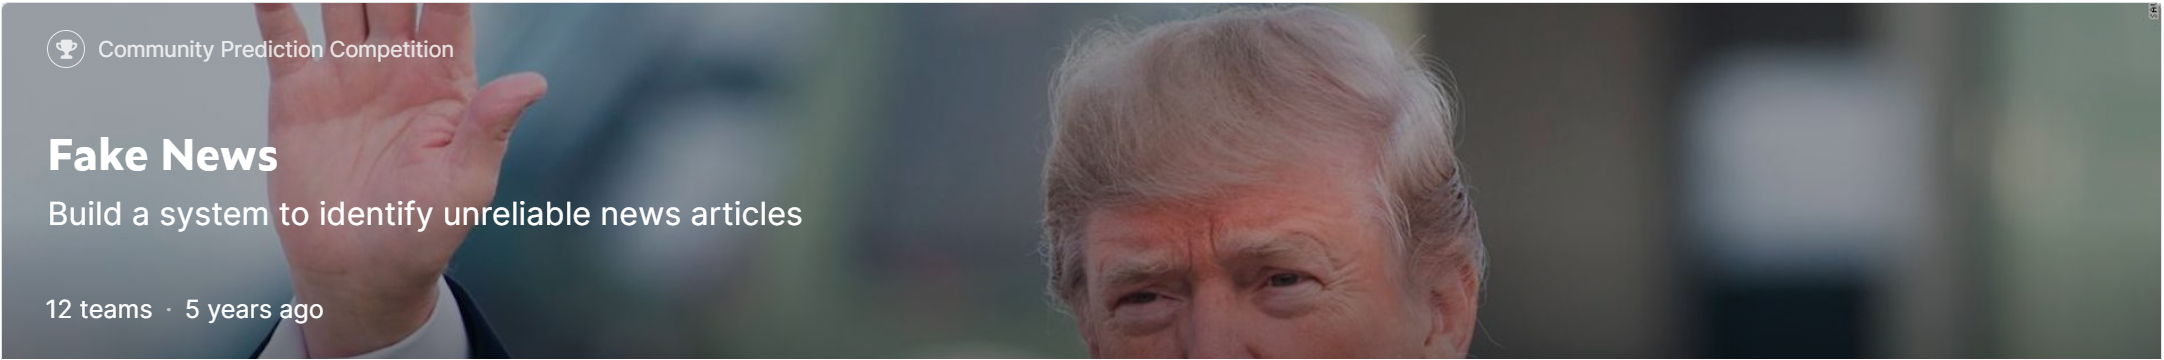

In [2]:
train=pd.read_csv('/kaggle/input/fake-news/train.csv')
train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [3]:
train.shape

(20800, 5)

In [4]:
features=[i for i  in train.columns if i not in ['label']]

In [5]:
features

['id', 'title', 'author', 'text']

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


# Handle Missing Values

There are Missing values where author name is not available, to make this meaningful let us fill the missing values with "unavailable" and this would be concistent for authorless titles

In [7]:
train.fillna('unavailable',inplace=True)

In [8]:
test=pd.read_csv('/kaggle/input/fake-news/test.csv')

In [9]:
test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5200 entries, 0 to 5199
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5200 non-null   int64 
 1   title   5078 non-null   object
 2   author  4697 non-null   object
 3   text    5193 non-null   object
dtypes: int64(1), object(3)
memory usage: 162.6+ KB


In [11]:
test.fillna('unavailable',inplace=True)

In [12]:
df=pd.concat([train,test],axis='rows')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26000 entries, 0 to 5199
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      26000 non-null  int64  
 1   title   26000 non-null  object 
 2   author  26000 non-null  object 
 3   text    26000 non-null  object 
 4   label   20800 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 1.2+ MB


To make a single column that can be used for building the model, columns 'author' and 'title' are combined, the author comes first followed by the title. At the moment, the text can be ignored. Let us see if we can build a model just with title and author

In [14]:
df['comb']=df['author']+"_"+df['title']#+df['text']      # Combined all the features 

# Clean Text Data

This this standard cleaning, we remove all the stopwords and unncessary text other than alphabet

In [15]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [16]:
import string
import re
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [17]:
wordnet=WordNetLemmatizer()
stemmer=PorterStemmer()
def clean(text):
    # text="".join([char for char in text if char not in string.punctuation])
    text="".join([re.sub('[^a-zA-Z]',' ',char) for char in text ])
    text=text.lower()
    text=text.split()
    text=[stemmer.stem(word) for word in text if word not in set(stopwords.words("english"))]
    text=" ".join(text)
    return text

In [18]:
df['comb']=df['comb'].apply(clean)

In [19]:
df.head()


,id,title,author,text,label,comb
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1.0,darrel lucu hous dem aid even see comey letter...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0.0,daniel j flynn flynn hillari clinton big woman...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1.0,consortiumnew com truth might get fire
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1.0,jessica purkiss civilian kill singl us airstri...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1.0,howard portnoy iranian woman jail fiction unpu...


# Text to Numbers using Word Embeddings - onehot

**one_hot** is a function provided by the Keras deep learning library, which is a part of TensorFlow, used for creating one-hot encoded representations of text data.

In natural language processing, text data needs to be transformed into a numerical representation before it can be processed by machine learning models. One common approach is to represent each word in the text with a unique integer index and then use this index as an input to the model. However, this approach can lead to the curse of dimensionality since the vocabulary size can be very large.

One way to mitigate the curse of dimensionality is to use a one-hot encoding. In this encoding, each word is represented as a binary vector of the same length as the vocabulary size, where all values are zero except for the index corresponding to the word, which is set to one. This ensures that each word is represented by a vector of the same length, irrespective of the vocabulary size.

The **one_hot** function in Keras provides an easy way to create one-hot encoded representations of text data. It takes two arguments: the input text and the vocabulary size. The function returns a list of integers, where each integer represents the index of a word in the vocabulary, which can then be used as input to a machine learning model.

In [20]:
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tfx-bsl 1.12.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.82.0 which is incompatible.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
apache-beam 2.44.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.


In [21]:
import tensorflow
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Bidirectional

In [22]:
voc_size=30000   # Vocabulary size

In [23]:
title=df['comb']
title[0]

0    darrel lucu hous dem aid even see comey letter...
0    david streitfeld specter trump loosen tongu pu...
Name: comb, dtype: object

In [24]:
one_hot_r=[one_hot(words, voc_size) for words in title]

In [25]:
one_hot_r[0:2]

[[20932,
  6662,
  27665,
  1258,
  27883,
  19072,
  16254,
  17147,
  15022,
  3672,
  19439,
  18286],
 [10916, 20660, 25327, 25327, 4265, 12983, 6762, 11891, 10168, 18046]]

In [26]:
sent_len=50
embedded_docs=pad_sequences(one_hot_r,padding='post',maxlen=sent_len)

In [27]:
embedded_docs[:10]

array([[20932,  6662, 27665,  1258, 27883, 19072, 16254, 17147, 15022,
         3672, 19439, 18286,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0],
       [10916, 20660, 25327, 25327,  4265, 12983,  6762, 11891, 10168,
        18046,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0],
       [ 5425, 17693, 12114,  9658, 24627, 13635,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,    

# Model- Bidirectional LSTM
A **Bidirectional LSTM (Bi-LSTM)** is a type of recurrent neural network (RNN) that is capable of processing input data in both forward and backward directions. Unlike a traditional RNN or a unidirectional LSTM, which only takes into account the previous information in the sequence, a Bi-LSTM takes both the past and future context of the input data into account.

The basic structure of a Bi-LSTM consists of two LSTM layers, one processing the input sequence in a forward direction and the other processing it in a backward direction. The outputs from both layers are then concatenated to produce the final output. By doing this, the Bi-LSTM is able to capture more contextual information about the input sequence, leading to better performance in tasks such as sequence tagging, speech recognition, and machine translation.

The Bi-LSTM architecture can be visualized as follows:


In [28]:
'''
<--- LSTM Layer 1 <---
         /                        \
Input -->                          Concatenation --> Output
         \                        /
          ---> LSTM Layer 2 --->
'''


'\n<--- LSTM Layer 1 <---\n         /                        Input -->                          Concatenation --> Output\n         \\                        /\n          ---> LSTM Layer 2 --->\n'

## Optimizers

In [29]:
sgd=tensorflow.keras.optimizers.SGD(learning_rate=0.01,momentum=0.9, nesterov=True)
rms = tensorflow.keras.optimizers.RMSprop()
nadam=tensorflow.keras.optimizers.Nadam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam"
)

In [30]:
embedding_vector_features=50
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_len))
# model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(100)))  # used Bidirectional LSTM
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer=nadam,metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            1500000   
                                                                 
 bidirectional (Bidirectiona  (None, 200)              120800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 1,621,001
Trainable params: 1,621,001
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
len(embedded_docs)

26000

In [32]:
X=embedded_docs[:train.shape[0]]
y=df['label'][:train.shape[0]]
x_test=embedded_docs[train.shape[0]:]

# Split data for training and testing

In [33]:
X_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
model.fit(X_train,y_train,validation_data=(x_valid,y_valid),epochs=4,batch_size=124)

Epoch 1/4
135/135 [==============================] - 26s 154ms/step - loss: 0.3239 - accuracy: 0.8641 - val_loss: 0.0694 - val_accuracy: 0.9788
Epoch 2/4
135/135 [==============================] - 20s 148ms/step - loss: 0.0260 - accuracy: 0.9923 - val_loss: 0.0418 - val_accuracy: 0.9880
Epoch 3/4
135/135 [==============================] - 20s 146ms/step - loss: 0.0065 - accuracy: 0.9990 - val_loss: 0.0386 - val_accuracy: 0.9894
Epoch 4/4
135/135 [==============================] - 20s 147ms/step - loss: 0.0026 - accuracy: 0.9997 - val_loss: 0.0342 - val_accuracy: 0.9899


In [35]:
y_pred_prob=np.array(model.predict(X_train))[:,0]
y_pred_valid=np.array(model.predict(x_valid))[:,0]
y_pred=np.array(model.predict(x_test))[:,0]

163/163 [==============================] - 3s 15ms/step


# Model Performance on Validation Set

In [36]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_valid, y_pred_valid)

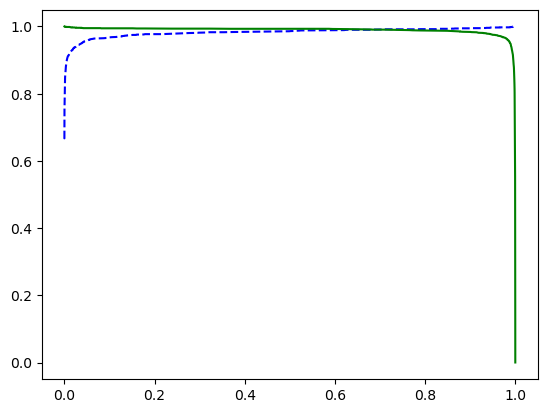

In [37]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
[...]
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

# Decision boundary to identify classes

Select the decision boundary by testing the accuracy at each threshold and select the threshold where the accuracy is maximum

In [38]:
A=[]
B=[]
C=[]
for i in range(len(thresholds)):
    predicted = pd.DataFrame()
    predicted["label"] = y_pred_prob
    predicted["label"] = np.where(predicted["label"] > float(thresholds[i]), 1, 0)
    pred_valid = pd.DataFrame()
    pred_valid["label"] = y_pred_valid
    pred_valid["label"] = np.where(pred_valid["label"] > float(thresholds[i]), 1, 0)
    A.append(metrics.accuracy_score(y_train, predicted))
    B.append(metrics.accuracy_score(y_valid, pred_valid))
    C.append(thresholds[i])
acc=pd.DataFrame(C,columns=['threshold'])
acc['train_acc']=A
acc['test_acc']=B
acc.sort_values(by='test_acc',ascending=False,inplace=True)

In [39]:
acc.head()

,threshold,train_acc,test_acc
1012,0.707865,0.99988,0.991346
1006,0.621625,0.99988,0.991346
1013,0.707941,0.99988,0.991106
1011,0.681824,0.99988,0.991106
1009,0.678405,0.99988,0.991106


In [40]:
cutoff=acc.iloc[0,0]
cutoff

0.7078652

In [41]:
predicted = pd.DataFrame()
predicted["label"] = y_pred_prob
predicted["label"] = np.where(predicted["label"] > float(cutoff), 1, 0)
predicted

pred_valid = pd.DataFrame()
pred_valid["label"] = y_pred_valid
pred_valid["label"] = np.where(pred_valid["label"] > float(cutoff), 1, 0)
pred_valid

predictions = pd.DataFrame()
predictions['label'] = y_pred
predictions['label'] = np.where(predictions['label'] > float(cutoff), 1, 0)
predictions

,label
0,0
1,1
2,1
3,0
4,1
...,...
5195,0
5196,0
5197,0
5198,1


In [42]:
from sklearn.metrics import roc_auc_score

## Performance on Train Data

In [43]:
conf_matrix = metrics.confusion_matrix(y_train, predicted)
print(conf_matrix)
acc_train = metrics.accuracy_score(y_train, predicted)
print('Accuracy: ',acc_train)
precision_train = metrics.precision_score(y_train, predicted)
print('Presicion: ',precision_train)
sensitivity_train = metrics.recall_score(y_train, predicted)
print('Recall: ',sensitivity_train)
specificity_train = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1])
print('Specificity: ',specificity_train)
roc_auc_score(y_train, predicted)

[[8255    0]
 [   2 8383]]
Accuracy:  0.9998798076923077
Presicion:  1.0
Recall:  0.9997614788312462
Specificity:  1.0


0.999880739415623

## Performance on Validation set Data

In [44]:
conf_matrix = metrics.confusion_matrix(y_valid, pred_valid)
print(conf_matrix)

acc_train = metrics.accuracy_score(y_valid, pred_valid)
print('Accuracy: ',acc_train)
precision_train = metrics.precision_score(y_valid, pred_valid)
print('Precision: ',precision_train)
sensitivity_train = metrics.recall_score(y_valid, pred_valid)
print('Recall: ',sensitivity_train)
specificity_train = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1])
print('Specificity: ',specificity_train)
roc_auc_score(y_valid, pred_valid)

[[2115   17]
 [  19 2009]]
Accuracy:  0.9913461538461539
Precision:  0.991609081934847
Recall:  0.9906311637080868
Specificity:  0.9920262664165104


0.9913287150622986

In [45]:
from sklearn.metrics import f1_score
print(f1_score(y_train, predicted,average='macro'))
f1_score(y_valid, pred_valid,average='macro')

0.999879800579916


0.9913405315165102

In [46]:
submit=pd.read_csv('/kaggle/input/fake-news/submit.csv')

In [47]:
submit['label']=predictions['label']

In [48]:
submit.to_csv('submission.csv',index=False)

Please share your thoughts and upvote if you liked the work. Thank you!